In [16]:
import pandas as pd
import warnings
import pandas_datareader as pdr
#import prophet as ph
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
df=pdr.DataReader('LSEG.UK', 'stooq')        #LONDON STOCK EXCHANGE GROUP

In [3]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2023-01-25,7288.00,7296.00,7140.00,7296.00,1.064852e+06
2023-01-24,7360.00,7374.00,7256.00,7264.00,1.312243e+06
2023-01-23,7502.00,7562.00,7310.00,7328.00,1.070813e+06
2023-01-20,7514.00,7544.00,7450.00,7490.00,9.006390e+05
2023-01-19,7564.00,7606.00,7466.00,7498.00,9.777540e+05
...,...,...,...,...,...
2021-02-04,9129.68,9207.89,9086.66,9188.33,4.461539e+05
2021-02-03,9205.94,9274.38,8994.75,9043.63,5.849295e+05
2021-02-02,9039.74,9221.59,8916.53,9190.30,6.129559e+05


<AxesSubplot:xlabel='Date'>

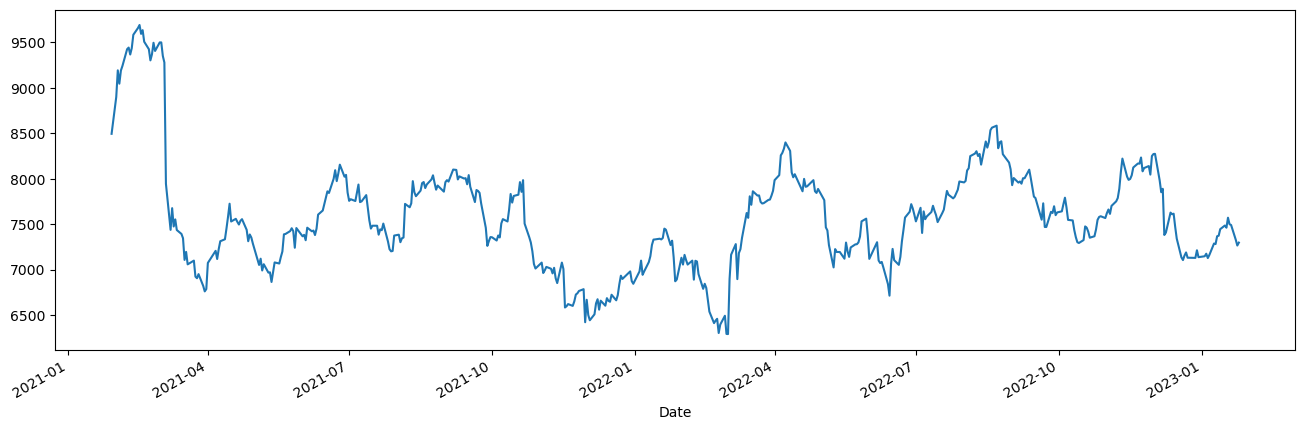

In [4]:
df['Close'].plot(figsize=(16,5))

In [5]:
df.drop(columns=['Low', 'Open', 'High', 'Volume'],axis=1,inplace=True)

In [6]:
df

,Close
Date,
2023-01-25,7296.00
2023-01-24,7264.00
2023-01-23,7328.00
2023-01-20,7490.00
2023-01-19,7498.00
...,...
2021-02-04,9188.33
2021-02-03,9043.63
2021-02-02,9190.30


In [7]:
Stock=pd.DataFrame(df['Close']['2022-01-01':'2023-01-01'])

<AxesSubplot:xlabel='Date'>

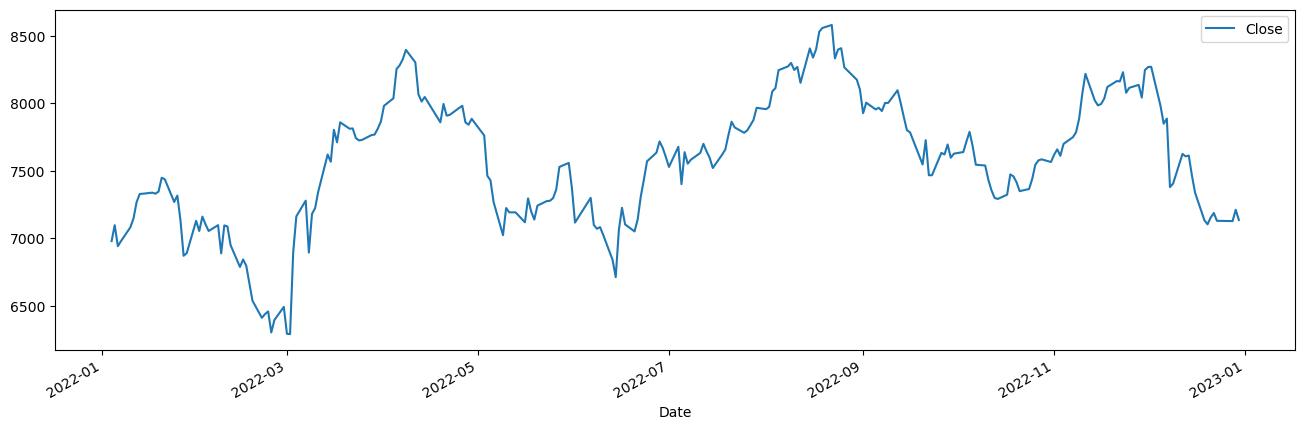

In [8]:
Stock.plot(figsize=(16,5))

## Now we will check whether the data is stationary or not 

In [9]:
#Method 1 :  Rolling Statistics
#Method2 :   Duckey fuller

#### Method1

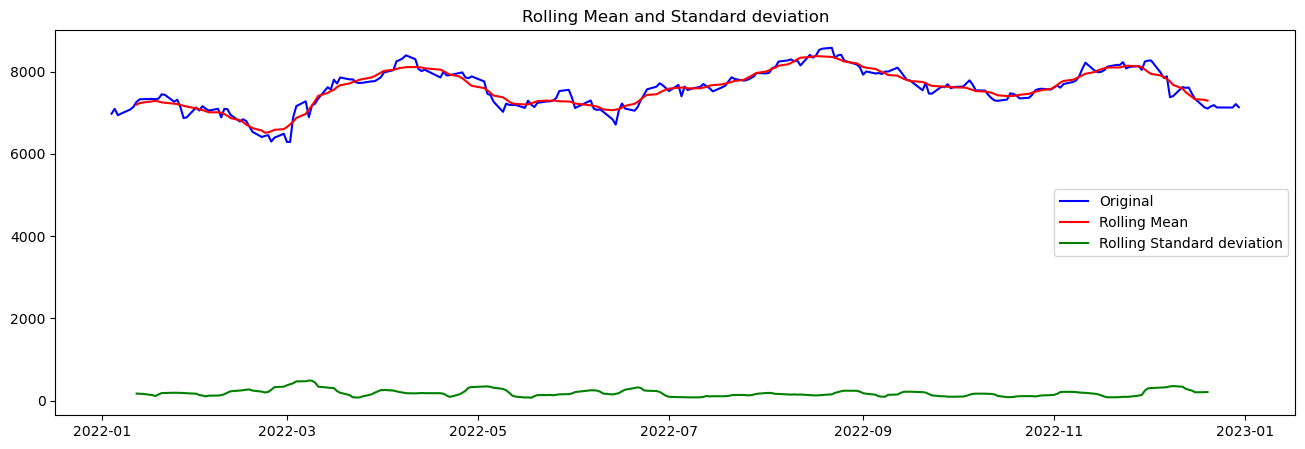

In [9]:
rollmean=Stock.rolling(13,center=True).mean()
rollstd=Stock.rolling(13,center=True).std()

plt.figure(figsize=(16,5))
fig=plt.figure(1)

original=plt.plot(Stock,color='blue',label='Original')
mean=plt.plot(rollmean,color='red',label='Rolling Mean')
std=plt.plot(rollstd,color='green',label='Rolling Standard deviation')
plt.legend()
plt.title("Rolling Mean and Standard deviation")
plt.show()

In [10]:
#We can seee that rolling std has not a flat line so we can conclude that it is not stationary 
#So we will make it stationary

In [10]:
import numpy as np
log_stock=np.log(Stock)
log_stock

,Close
Date,
2022-12-30,8.872908
2022-12-29,8.883502
2022-12-28,8.871786
2022-12-23,8.872067
2022-12-22,8.880168
...,...
2022-01-10,8.865341
2022-01-07,8.850734
2022-01-06,8.845344


In [47]:
log_stock['Date']=pd.to_numeric(pd.to_datetime(log_stock['Date']))

KeyError: 'Date'

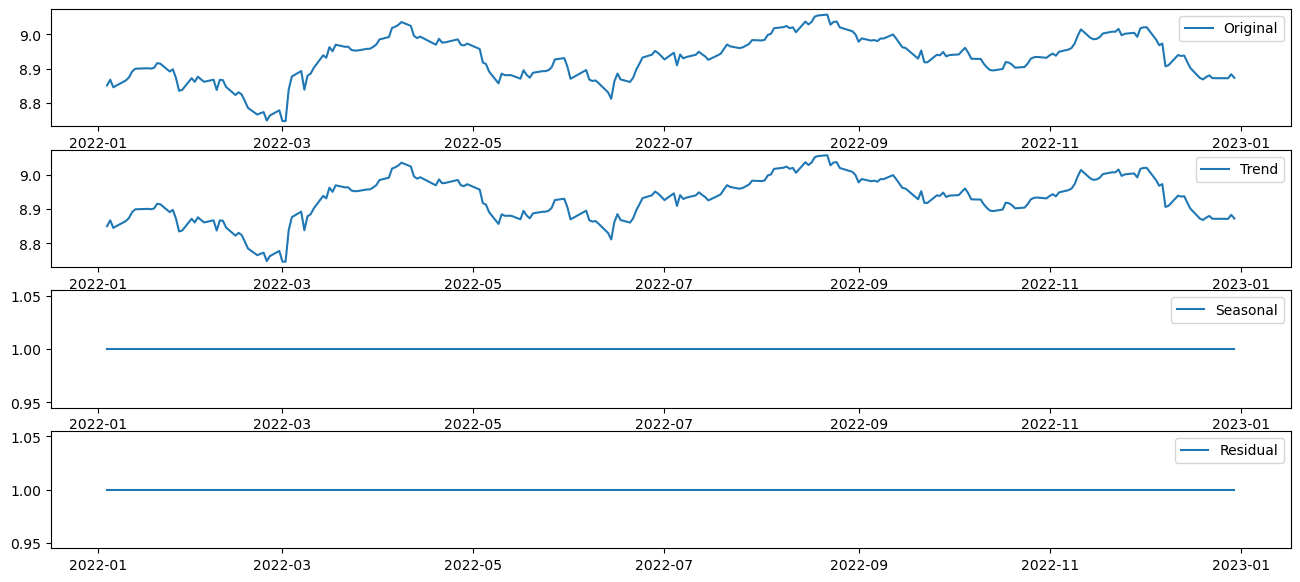

In [12]:
#Decomposition 

from statsmodels.tsa.seasonal import seasonal_decompose
decompose=seasonal_decompose(x=log_stock['Close'] ,model='multiplicative',extrapolate_trend=0, period=1)


trend= decompose.trend
seasonal=decompose.seasonal
residual=decompose.resid

plt.figure(figsize=(16,7))
plt.subplot(411)
plt.plot(log_stock['Close'],label="Original")
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend,label="Trend")
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label="Seasonal")
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual,label="Residual")
plt.legend(loc='best')

In [49]:
#This shows that there is no seasonality 

#Therefore we will try differencing

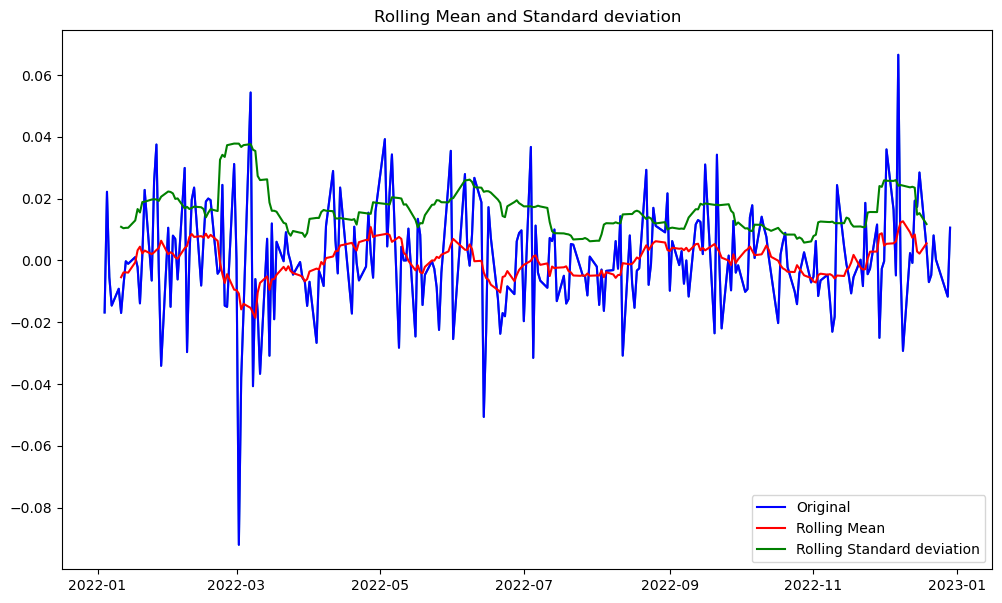

In [13]:
plt.figure(figsize=(12,7))

log_stock_diff=log_stock-log_stock.shift()
plt.plot(log_stock_diff)

#Rolling Mead and STD
rollmean_diff=log_stock_diff.rolling(12,center=True).mean()
rollstd_diff=log_stock_diff.rolling(12,center=True).std()

#PLotting rolling mean and std
original=plt.plot(log_stock_diff,color='blue',label='Original')
mean=plt.plot(rollmean_diff,color='red',label='Rolling Mean')
std=plt.plot(rollstd_diff,color='green',label='Rolling Standard deviation')
plt.legend(loc='best')
plt.title("Rolling Mean and Standard deviation")
plt.show()

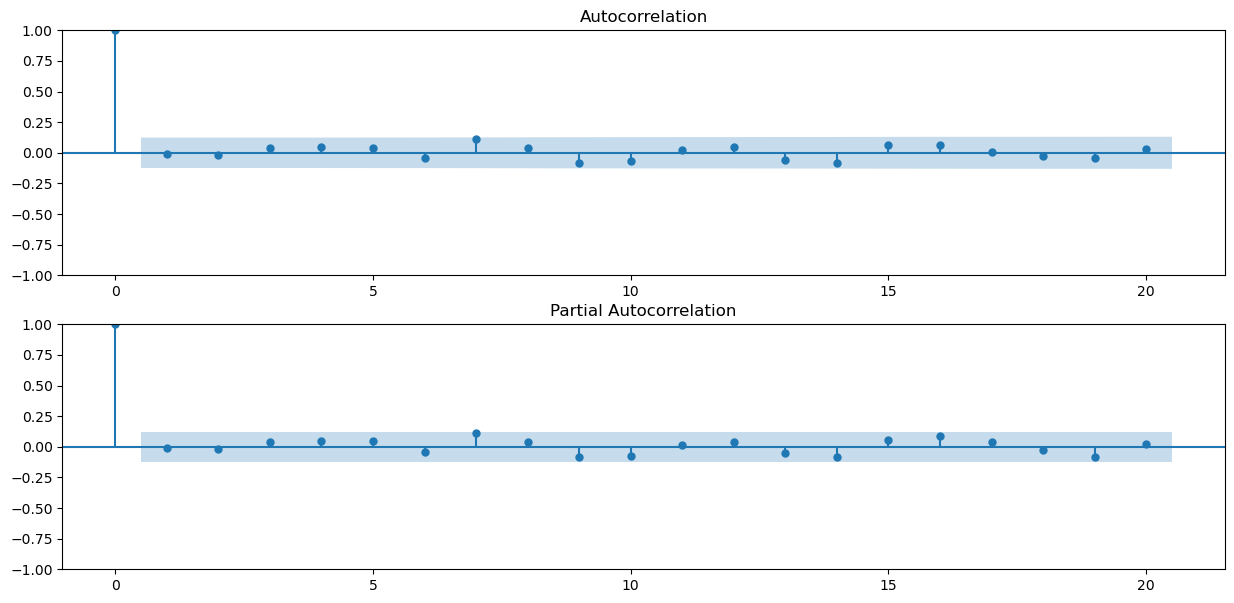

In [14]:
import statsmodels.api as sm
fig=plt.figure(figsize=(15,7))
ax1=fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(log_stock_diff.dropna(),lags=20,ax=ax1)
ax2=fig.add_subplot(212)
fig=sm.graphics.tsa.plot_pacf(log_stock_diff.dropna(),lags=20,ax=ax2)

In [60]:
#Loooking a the graph , we can conclude that p and q value shoul be 7

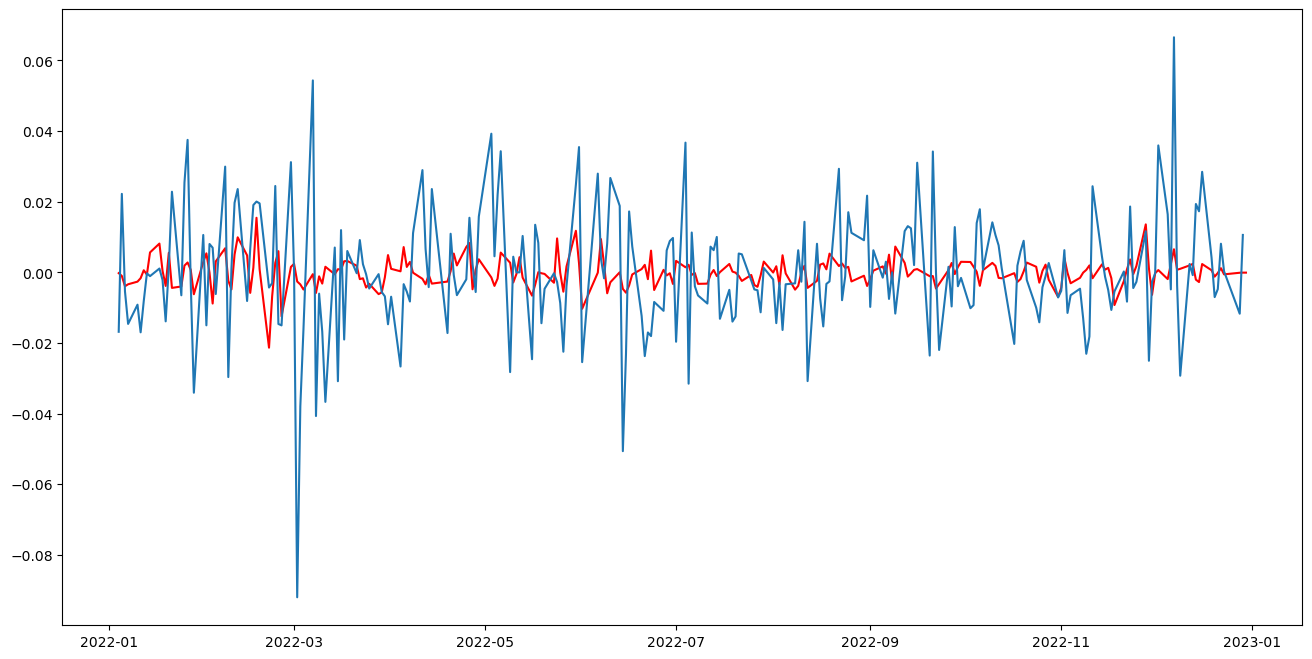

In [19]:
from statsmodels.tsa.arima.model import ARIMA
plt.figure(figsize=(16,8))
model=ARIMA(log_stock_diff,order=(7,0,7))
model_arima=model.fit()
plt.plot(model_arima.fittedvalues,color='red')
plt.plot(log_stock_diff)
plt.show()

### Taking result back to the original scale

In [93]:
arima_pred=(pd.DataFrame(model_arima.fittedvalues,copy=True)).cumsum()
arima_log_pred=pd.DataFrame(log_stock.values,index=log_stock.index)
arima_log_pred=arima_log_pred.add(arima_pred)

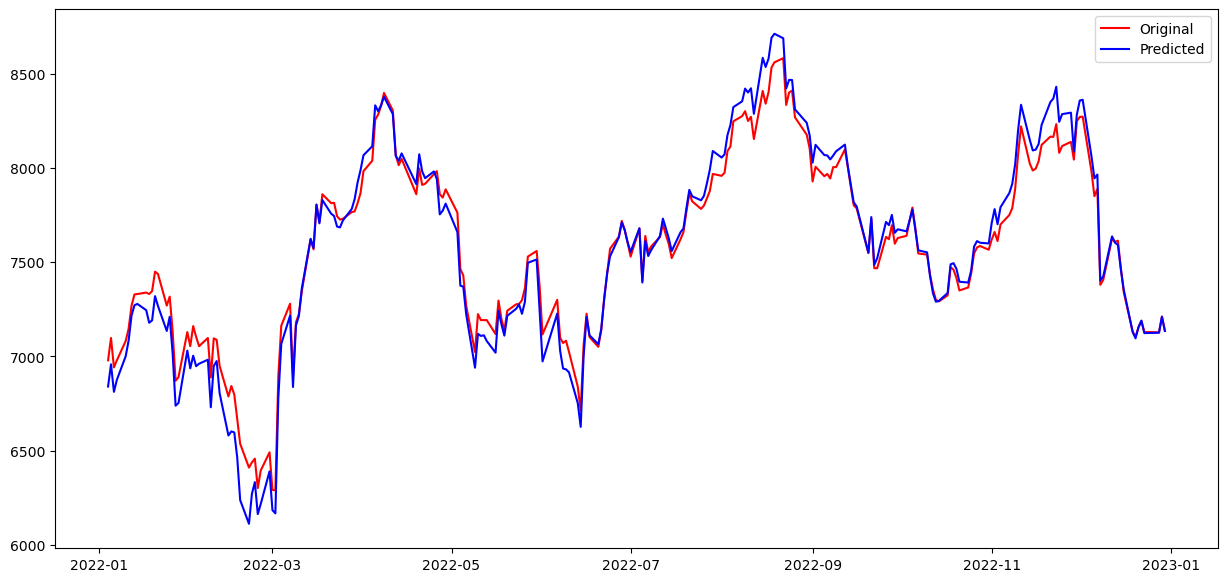

In [94]:
plt.figure(figsize=(15,7))
pred=np.exp(arima_log_pred)
plt.plot(Stock,color='red',label='Original')
plt.plot(pred,color='blue',label='Predicted')
plt.legend(loc='best')
plt.show()

In [97]:
forecast= model_arima.predict(start = 102, end= 120, dynamic= True)

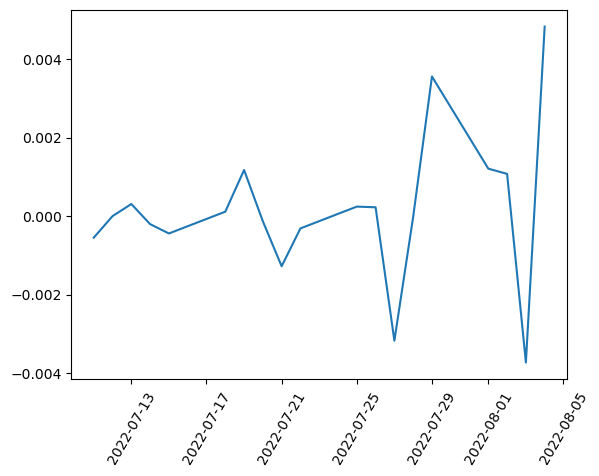

In [102]:
plt.plot(forecast)
plt.xticks(rotation=60)
plt.show()

1264   -0.000083
dtype: float64